In [1]:
import autogluon as ag
from autogluon import ImageClassification as task

/home/weiweia92/anaconda3/lib/python3.7/site-packages/mxnet/optimizer/optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [2]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')

In [3]:
ag.unzip(filename)

'data'

In [4]:
dataset = task.Dataset('data/train')

In [5]:
dataset

AutoGluonObject

In [6]:
test_dataset = task.Dataset('data/test', train=False)

In [7]:
if ag.get_gpu_count() == 0:
    dataset = task.Dataset(name='FashionMNIST')
    test_dataset = task.Dataset(name='FashionMNIST', train=False)

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://10.123.6.74/2035/1' processes=1 threads=16, memory=67.56 GB>, Resource: NodeResourceManager(16 CPUs, 1 GPUs))
})



Saving Training Curve in checkpoint/plot_training_curves.png


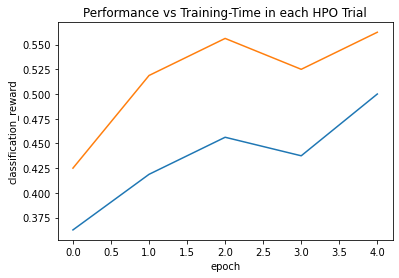

In [8]:
classifier = task.fit(dataset,
                      epochs=5,
                      ngpus_per_trial=1,
                      verbose=False)

In [9]:
print('Top-1 val acc: %.3f' % classifier.results['best_reward'])

Top-1 val acc: 0.562


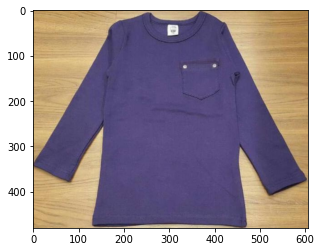

The input picture is classified as [BabyShirt], with probability 0.49.


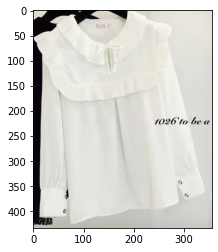

The input picture is classified as [BabyShirt], with probability 0.35.


In [11]:
if ag.get_gpu_count() > 0:
    image = 'data/test/BabyShirt/BabyShirt_323.jpg'
    ind, prob, _ = classifier.predict(image, plot=True)

    print('The input picture is classified as [%s], with probability %.2f.' %
          (dataset.init().classes[ind.asscalar()], prob.asscalar()))

    image = 'data/test/womenchiffontop/womenchiffontop_184.jpg'
    ind, prob, _ = classifier.predict(image, plot=True)

    print('The input picture is classified as [%s], with probability %.2f.' %
          (dataset.init().classes[ind.asscalar()], prob.asscalar()))

In [12]:
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.688


## Networks

In [13]:
import gluoncv as gcv

@ag.func(
    multiplier=ag.Categorical(0.25, 0.5),
)
def get_mobilenet(multiplier):
    return gcv.model_zoo.MobileNetV2(multiplier=multiplier, classes=4)

net = ag.space.Categorical('mobilenet0.25', get_mobilenet())
print(net)

Categorical['mobilenet0.25', AutoGluonObject]


## Optimizer,lr,momentum,wd

In [14]:
from mxnet import optimizer as optim

@ag.obj(
    learning_rate=ag.space.Real(1e-4, 1e-2, log=True),
    momentum=ag.space.Real(0.85, 0.95),
    wd=ag.space.Real(1e-6, 1e-2, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


## Search Algorithms
### Bayesian Optimization

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2
Time out (secs) is 120


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://10.123.6.74/2035/1' processes=1 threads=16, memory=67.56 GB>, Resource: NodeResourceManager(16 CPUs, 1 GPUs))
})



Model file not found. Downloading.


100%|██████████| 1093/1093 [00:02<00:00, 418.29KB/s]


Saving Training Curve in checkpoint/plot_training_curves.png


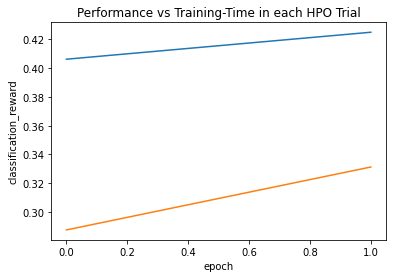

Top-1 val acc: 0.425


In [15]:
time_limits = 2*60
epochs = 2

classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy='skopt',
                      search_options={'base_estimator': 'RF', 'acq_func': 'EI'},
                      time_limits=time_limits,
                      epochs=epochs,
                      ngpus_per_trial=1)

print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])